In [1]:
import numpy as np
import torch
from torch import nn, optim, autograd
from torch.nn import functional as F
from pyDOE import lhs
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models_all import *

#Paper reproduction
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)

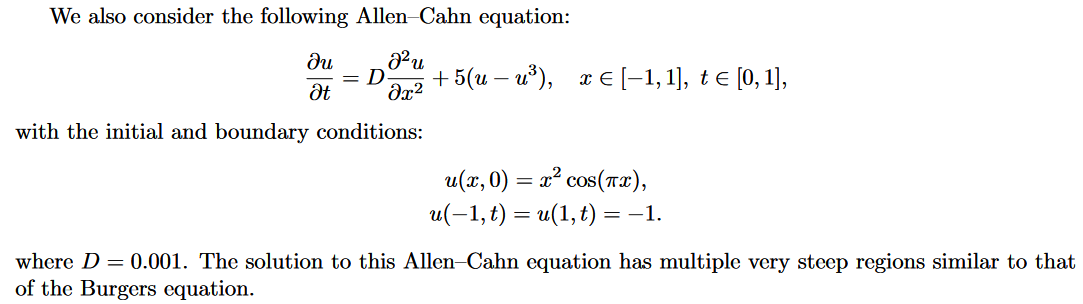

In [2]:
N_train = 2000
N_bound = 100

la = np.array([1,1])
lb = np.array([-1,0])

traindata = lb+(la-lb)*lhs(2,N_train)

bound_x = -1+(1-(-1))*lhs(1,N_bound)

bound_t = 0+(1-(0))*lhs(1,N_bound)

#x,t  #u,v
X_train = torch.from_numpy(traindata).float()
x_bound = torch.from_numpy(bound_x).float()
t_bound = torch.from_numpy(bound_t).float()
x = X_train[:,0:1]
t = X_train[:,1:2]

x.requires_grad_()
t.requires_grad_()

###########GPU###########
x_bound = x_bound.cuda()
t_bound = t_bound.cuda()
x = x.cuda()
t = t.cuda()
###########GPU###########

In [3]:
from scipy.io import loadmat
def gen_testdata():
    data = loadmat("usol_D_0.001_k_5.mat")

    t = data["t"]

    x = data["x"]

    u = data["u"]

    dt = dx = 0.01

    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = u.flatten()[:, None]
    return X, y

In [4]:
n = 100
true_data,true_u = gen_testdata()
index_observe = (lhs(1,n))*true_data.shape[0]
index_observe = np.floor(index_observe).reshape(n,).astype(int)
observe_data = true_data[index_observe,:]
observe_u = true_u[index_observe,:]

In [5]:
observe_data = torch.from_numpy(observe_data).float()
observe_u = torch.from_numpy(observe_u).float()

In [6]:
C1 = torch.tensor(0.1, requires_grad=True)

In [7]:
###########GPU###########
observe_u = observe_u.cuda()
observe_data = observe_data.cuda()
###########GPU###########

In [8]:
print('J:',len(observe_u))

J: 100


In [9]:
def output_transform(x, y):
    return x[:, 0:1]**2 * torch.cos(torch.tensor(np.pi) * x[:, 0:1]) + x[:, 1:2] * (1 - x[:, 0:1]**2) * y

In [10]:
test_data,test_u = gen_testdata()
test_data = torch.from_numpy(test_data).float()
test_u = torch.from_numpy(test_u).float()
###########GPU###########
test_data = test_data.cuda()
test_u = test_u.cuda()
###########GPU###########

In [11]:
def relative_l2(u_pred, u_real):

    l2 = torch.norm(u_real - u_pred, p=2) / torch.norm(u_real, p=2)
    
    return l2.item()  # Convert the result back to a Python float

## PINN

In [12]:
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)


PINNs1 = NN_H2(2, 64, 4, 1)
PINNs1.cuda()

#PINNs1.apply(weights_init)
import torch.nn.init as init
for name, param in PINNs1.named_parameters():
    if 'weight' in name:
        init.xavier_uniform_(param)


optimizer1 = optim.Adam(PINNs1.parameters(), lr=0.001,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

        
optimizer1.add_param_group({'params': [C1], 'lr': 0.001})

loss_all_1 = []
test_loss_1 = []
C1_list = []

nIter1 = 10000

loss1_value = 1
it = 0

while it<7000:
    ##### loss f  ######

    E_inside = PINNs1(torch.cat((x,t),axis=1))
    
    E_inside = output_transform(torch.cat((x,t),axis=1), E_inside)
    
    E_x = autograd.grad(outputs=E_inside, inputs=x,
                              grad_outputs=torch.ones_like(E_inside),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    E_xx = autograd.grad(outputs=E_x, inputs=x,
                              grad_outputs=torch.ones_like(E_x),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    E_xxx = autograd.grad(outputs=E_xx, inputs=x,
                              grad_outputs=torch.ones_like(E_xx),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    E_xxt = autograd.grad(outputs=E_xx, inputs=t,
                              grad_outputs=torch.ones_like(E_xx),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    
    
    E_t = autograd.grad(outputs=E_inside, inputs=t,
                              grad_outputs=torch.ones_like(E_inside),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]     
    E_tx = autograd.grad(outputs=E_t, inputs=x,
                              grad_outputs=torch.ones_like(E_t),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]   
    E_tt = autograd.grad(outputs=E_t, inputs=t,
                              grad_outputs=torch.ones_like(E_t),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]   
    
    
    loss_f = torch.mean(torch.square(E_t-C1*(E_xx)-5*(E_inside-E_inside**3)))

    ##### loss observation  ######        
    E_observation = PINNs1(observe_data)
    E_observation = output_transform(observe_data, E_observation)                              
                                
    loss_observation = torch.mean(torch.square(E_observation-observe_u))      


    #####loss PI#######
    loss = loss_f+10*loss_observation
    
    loss_all_1.append(loss.item())
    loss1_value = loss.item()
    optimizer1.zero_grad()
    loss.backward()
    optimizer1.step()

    
    if (it % 500 == 0 and it!=0) or it==6999:
        print('It:', it, 'Loss:', loss.item())

        N_train = 2000
        N_bound = 100

        la = np.array([1,1])
        lb = np.array([-1,0])

        traindata = lb+(la-lb)*lhs(2,N_train)

        bound_x = -1+(1-(-1))*lhs(1,N_bound)

        bound_t = 0+(1-(0))*lhs(1,N_bound)

        #x,t  #u,v
        X_train = torch.from_numpy(traindata).float()
        x_bound = torch.from_numpy(bound_x).float()
        t_bound = torch.from_numpy(bound_t).float()
        x = X_train[:,0:1]
        t = X_train[:,1:2]

        x.requires_grad_()
        t.requires_grad_()
        
        ###########GPU###########
        x_bound = x_bound.cuda()
        t_bound = t_bound.cuda()
        x = x.cuda()
        t = t.cuda()
        ###########GPU###########
        C1_list.append(C1.detach().item())
        print(C1)
        #########  test_loss NRMSE  #########
        pre_u = PINNs1(test_data)
        pre_u = output_transform(test_data, pre_u) 
                 
        test_loss = relative_l2(pre_u,test_u)
        test_loss_1.append(test_loss)
    
    it = it + 1        
loss1_value    

It: 500 Loss: 0.035381875932216644
tensor(0.0044, requires_grad=True)
It: 1000 Loss: 0.009512444026768208
tensor(0.0027, requires_grad=True)
It: 1500 Loss: 0.004990034736692905
tensor(0.0021, requires_grad=True)
It: 2000 Loss: 0.002814867068082094
tensor(0.0018, requires_grad=True)
It: 2500 Loss: 0.0032602273859083652
tensor(0.0015, requires_grad=True)
It: 3000 Loss: 0.023410214111208916
tensor(0.0015, requires_grad=True)
It: 3500 Loss: 0.0012611998245120049
tensor(0.0014, requires_grad=True)
It: 4000 Loss: 0.005446716211736202
tensor(0.0013, requires_grad=True)
It: 4500 Loss: 0.0005143231828697026
tensor(0.0013, requires_grad=True)
It: 5000 Loss: 0.0018418041290715337
tensor(0.0013, requires_grad=True)
It: 5500 Loss: 0.0017468262230977416
tensor(0.0012, requires_grad=True)
It: 6000 Loss: 0.002782433060929179
tensor(0.0011, requires_grad=True)
It: 6500 Loss: 0.00041513858013786376
tensor(0.0012, requires_grad=True)
It: 6999 Loss: 0.0023181610740721226
tensor(0.0011, requires_grad=True)

0.0023181610740721226

In [ ]:
# np.save('../experimental_data/J1/test_loss_1',test_loss_1)
# np.save('../experimental_data/J1/test_loss_2',test_loss_2)
# np.save('../experimental_data/J1/loss_all_1',loss_all_1)
# np.save('../experimental_data/J1/loss_all_2',loss_all_2)
# np.save('../experimental_data/J1/C1_list',C1_list)
# np.save('../experimental_data/J1/C2_list',C2_list)